# "Segmentez des clients d'un site e-commerce"
_Cleaning Notebook_

## 0 Preliminaries

In [32]:
# !pip install flake8 pycodestyle_magic
# !pip install gtts
# !pip install category-encoders
# !pip install mlxtend==0.17.3 # makes Google Colab asking for reboot
# !pip install ppscore

In [33]:
# !pip freeze > requirements_cleaning_eda.txt

Checking for PEP8 compliance

In [34]:
# %load_ext pycodestyle_magic
# %pycodestyle_on
# %pycodestyle_off

### 0.0 Importing Packages and Modules

Checking whether the notebook is on Colab or PC

In [35]:
import sys
is_colab = 'google.colab' in sys.modules
is_colab, sys.executable

(True, '/usr/bin/python3')

Mounting my Drive if on colab

In [36]:
if is_colab==True:
    from google.colab import files, output, drive
    drive.mount('/gdrive')
    %cd /gdrive
    print("You're on Google Colab")
else:
    print("You're on a PC")

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive
You're on Google Colab


Installations and importations required in the virtual environment.

In [37]:
import os
if is_colab==True:
    if os.getcwd()!='/gdrive/My Drive/--DATA SCIENCE/PROJET5/NOTEBOOKS':
        os.chdir('My Drive/--DATA SCIENCE/PROJET5/NOTEBOOKS')
else:
    if not (os.path.exists(os.getcwd()+'/requirements_cleaning_eda.txt') \
                     and os.path.exists(os.getcwd()+'/P5_functions.py')):
        print("ERROR: Make sure 'P5_functions.py' and 'requirements_cleaning_eda.txt' are in the current working directory")

!pip install -r requirements_cleaning_eda.txt
from P5_functions import *

Importation of modules and packages. 

In [38]:
import io
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor']='w'

Setting pandas display options

In [39]:
dictPdSettings = {'display.max_rows': 500, 'display.width': 100,
                    'display.max_colwidth': 100,
                    'display.float_format': lambda x: '%.2f' % x}
for k,v in dictPdSettings.items():
  pd.set_option(k,v)

To play audio text-to-speech during execution.

In [40]:
from IPython.display import Audio
from gtts import gTTS

def speak(text, lang='en'):
    with io.BytesIO() as f:
        gTTS(text=text, lang=lang).write_to_fp(f)
        f.seek(0)
        return Audio(f.read(), autoplay=True)

In [41]:
speak('Packages and modules successfully imported')

### 0.1 Importing the Aggregated Orders dataset

Let's load the dataframe of aggregated orders as well as the dataframe of aggregated customers.

This way, we'll be able to reconstruct the dataframe of customer on different slots of time later on.

In [42]:
if is_colab==True:
    # Importing database from my Drive
    print("Try to import data files in the notebook from myDrive...")
else:
    # Importing database from PC
    print("Try to import data files in the notebook from PC ('DATA')...")

df_cust = pd.read_csv('agg_customers.csv', sep=',', index_col='customer_unique_id',
                        encoding ='utf-8').drop(columns=['Unnamed: 0'])

df_orders = pd.read_csv('agg_orders.csv', sep=',', index_col='order_id',
                        encoding ='utf-8').drop(columns=['Unnamed: 0'])

print("-----> Importation of .csv in the notebook: OK")

Try to import data files in the notebook from myDrive...
-----> Importation of .csv in the notebook: OK


All the dates and timestamps in the dataframes are to be converted.

In [43]:
# Dates are converted in datetime format, and timedeltas in timedeltas
df_orders[['order_purchase_timestamp', 'max_limit_ship_date']] = \
    df_orders[['order_purchase_timestamp', 'max_limit_ship_date']]\
        .apply(lambda x: pd.to_datetime(x))
df_orders[['shipping_time', 'shipping_delay']] = \
    df_orders[['shipping_time', 'shipping_delay']]\
        .apply(lambda x: pd.to_timedelta(x))  
df_orders['cust_region'] = \
    df_orders['cust_region'].astype('object')

# Time in df_cust are already encoded in days (int)
df_cust['cust_region'] = \
    df_cust['cust_region'].astype('object')

In [44]:
df_orders.shape

(99441, 36)

In [45]:
df_orders.columns

Index(['customer_unique_id', 'cust_region', 'order_status', 'order_purchase_timestamp',
       'order_item_nb', 'product_volume_cm3', 'product_weight_g', 'mean_prod_descr_length',
       'shipping_time', 'shipping_delay', 'max_limit_ship_date', 'delivered', 'price',
       'freight_value', 'review_score', 'review_comment_length', 'payment_installments',
       'payment_value', 'paytype_boleto', 'paytype_credit_card', 'paytype_debit_card',
       'paytype_not_defined', 'paytype_voucher', 'cat_home', 'cat_furniture', 'cat_electronics',
       'cat_office', 'cat_diy', 'cat_food', 'cat_miscellaneous', 'cat_multimedia', 'cat_fashion',
       'cat_books', 'cat_hygiene', 'cat_unknown', 'cat_leisure'],
      dtype='object')

In [46]:
df_orders.dtypes.value_counts()

float64            28
object              3
timedelta64[ns]     2
datetime64[ns]      2
int64               1
dtype: int64

In [47]:
df_cust.dtypes.value_counts()

float64    34
int64       8
object      1
dtype: int64

In [48]:
speak('Dataset successfully imported')

### 0.2 Aggregation of the customers dataset on custom time slots 

If we need to recompute the dataset in another period of time, we just need to call the function below, indicating as argument the right t_min and t_max.

In [49]:
# Aggregation in a chosen time slot
# all customers (for max period of time): (96095, 22)

# t_min = pd.Timestamp('2017-10-17 17:30:18')
# t_max = pd.Timestamp('2018-01-01 17:30:18')

def generate_cust_df(df_orders, t_min=None, t_max=None):
    df_cust = create_agg_cust_df(df_orders, t_min=t_min, t_max=t_max)
    df_cust = create_features_cust_df(df_cust)
    return df_cust

# test_df_cust = generate_cust_df(df_orders, t_min=None, t_max=None)

In [50]:
df_cust.shape

(96096, 43)

## 1 Clustering

### 1.1 Data preprocessing

In [51]:
df_cust.columns

Index(['cust_region', 'mean_nb_items_per_ord', 'tot_nb_items', 'mean_freight_val_per_order',
       'tot_freight_val', 'mean_price_per_order', 'tot_price', 'tot_nb_deliv_ord',
       'avg_freight_payval_ratio', 'tot_nb_ord', 'mean_ship_delay', 'mean_ship_time',
       'single_purch', 'nb_not_rec_orders', 'time_since_last_purch', 'time_since_first_purch',
       'mean_prod_vol_cm3', 'tot_comment_length', 'mean_prod_descr_length', 'mean_prod_wei_g',
       'mean_comment_length', 'mean_rev_score', 'mean_pay_value_per_order', 'tot_pay_value',
       'paytype_not_defined_tot_nb', 'paytype_boleto_tot_nb', 'mean_pay_install',
       'paytype_voucher_tot_nb', 'paytype_debit_card_tot_nb', 'paytype_credit_card_tot_nb',
       'cat_multimedia_tot_nb', 'cat_office_tot_nb', 'cat_leisure_tot_nb', 'cat_home_tot_nb',
       'cat_food_tot_nb', 'cat_unknown_tot_nb', 'cat_diy_tot_nb', 'cat_electronics_tot_nb',
       'cat_furniture_tot_nb', 'cat_hygiene_tot_nb', 'cat_fashion_tot_nb',
       'cat_miscella

Here we use a custom transformer (see the class CustTransformer in P5_functions.py) to:
- encode categorical data with Ordinal Encoder
- Standardize the quantitative data with StandardScaler

In [52]:
# Transformation and encoding
ct = CustTransformer(strat_low_card='ohe',
                     strat_quant='stand')
ct.fit(df_cust)
df_cust_trans = ct.transform(df_cust)

In [53]:
df_cust_trans.columns

Index(['binary__single_purch', 'binary__paytype_not_defined_tot_nb', 'low_card__cust_region_1',
       'low_card__cust_region_2', 'low_card__cust_region_3', 'low_card__cust_region_4',
       'low_card__cust_region_5', 'mean_nb_items_per_ord', 'tot_nb_items',
       'mean_freight_val_per_order', 'tot_freight_val', 'mean_price_per_order', 'tot_price',
       'tot_nb_deliv_ord', 'avg_freight_payval_ratio', 'tot_nb_ord', 'mean_ship_delay',
       'mean_ship_time', 'nb_not_rec_orders', 'time_since_last_purch', 'time_since_first_purch',
       'mean_prod_vol_cm3', 'tot_comment_length', 'mean_prod_descr_length', 'mean_prod_wei_g',
       'mean_comment_length', 'mean_rev_score', 'mean_pay_value_per_order', 'tot_pay_value',
       'paytype_boleto_tot_nb', 'mean_pay_install', 'paytype_voucher_tot_nb',
       'paytype_debit_card_tot_nb', 'paytype_credit_card_tot_nb', 'cat_multimedia_tot_nb',
       'cat_office_tot_nb', 'cat_leisure_tot_nb', 'cat_home_tot_nb', 'cat_food_tot_nb',
       'cat_unknow

### 1.2 Features selection, features reduction

#### Variance Inflation Factor

We'll use the variance inflation factor (VIF) to find the colinear features in our transformed dataset.
NB: the VIF of a feature among a group of features can be defined as 1/(1-R²), where R² is the R² score of a simple regression of this features over all the others. If R² is high (and hence VIF), it means that the feature can be very well approximated using one or more of the other features, and thus is the source of colinearity.
In the "select_from_vif_" function, we eliminate the most highly correlated features and recalculate VIF of each feature. Usually, VIF should not exceed 5.

In [54]:
# select_from_vif_(df_cust_trans, thresh=0.5).columns

The columns exceeding a VIF of 5 are :
- low_card__cust_region_1', (the most frequent region)
- 'paytype_credit_card_tot_nb', (the most frequent payment)
- 'tot_comment_length', correlated with 'mean_comment_length'
- 'tot_nb_deliv_ord' and 'tot_nb_items', correlated resp. with 'tot_nb_ord' and - 'mean_nb_items_per_ord'
- 'mean_ship_delay', correlated with 'mean_ship_time'
- 'time_since_first_purch' correlated with 'time since_mast_purch'
- 'tot_price', 'tot_freight_val', 'tot_pay_value', mean_price_per_order', 'mean_pay_value_per_order', correlated with 'mean_nb_items_per_ord'

We decide to drop the foollowing columns:

In [55]:
col_vif_drop = ['time_since_first_purch', 'tot_comment_length',
                'tot_nb_deliv_ord', 'tot_nb_items', 'tot_pay_value',
                'paytype_credit_card_tot_nb', 'tot_freight_val',
                'mean_price_per_order', 'mean_pay_value_per_order',
                'mean_ship_delay']
df_cust_vif = df_cust.drop(columns=col_vif_drop)
df_cust_vif.shape

(96096, 33)

#### Low variance features

Checking for low variance features before transformation

In [56]:
# Transformation and encoding
ct = CustTransformer(strat_low_card='ohe', # One_Hot enc for categorical
                     strat_quant='none') # no standardization
df_enc = ct.fit_transform(df_cust_vif)

thresholds = [0,0.02,0.05,0.1,5,20,100,200,300,1000,5000,10000,25000,50000]

df_feat_var = check_feature_variance(thresholds, df_enc)

thresh=0 -> 0 excluded cols and 0 new ones: []
thresh=0.02 -> 4 excluded cols and 4 new ones: ['binary__paytype_not_defined_tot_nb', 'low_card__cust_region_3', 'avg_freight_payval_ratio', 'paytype_debit_card_tot_nb']
thresh=0.05 -> 7 excluded cols and 3 new ones: ['binary__single_purch', 'tot_nb_ord', 'nb_not_rec_orders']
thresh=0.1 -> 9 excluded cols and 2 new ones: ['low_card__cust_region_4', 'low_card__cust_region_5']
thresh=5 -> 14 excluded cols and 5 new ones: ['low_card__cust_region_1', 'low_card__cust_region_2', 'mean_nb_items_per_ord', 'mean_rev_score', 'paytype_boleto_tot_nb']
thresh=20 -> 16 excluded cols and 2 new ones: ['mean_pay_install', 'paytype_voucher_tot_nb']
thresh=100 -> 17 excluded cols and 1 new ones: ['mean_ship_time']
thresh=200 -> 19 excluded cols and 2 new ones: ['cat_food_tot_nb', 'cat_books_tot_nb']
thresh=300 -> 20 excluded cols and 1 new ones: ['cat_multimedia_tot_nb']
thresh=1000 -> 23 excluded cols and 3 new ones: ['mean_freight_val_per_order', 'cat_unkn

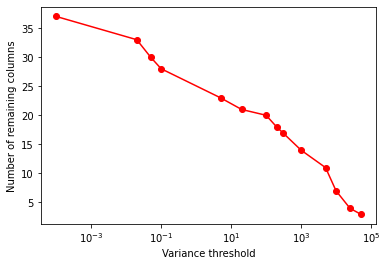

In [57]:
plt.plot(df_feat_var['thresh']+0.0001, df_feat_var['n_rem_cols'],  '-or')

ax = plt.gca()
ax.set_xlabel('Variance threshold')
ax.set_ylabel('Number of remaining columns')
ax.set_xscale('log')
# ax.set_yscale('log')

A lot of feature have low variance, but it is partially due to the scale of the data. Let's try several quantitative transformations to see if the variance of these data can be increased. 

In [58]:
# Transformation and encoding
ct1 = CustTransformer(strat_low_card='ohe', # One_Hot enc for categorical
                     strat_quant='none') # no transformation
df_enc = ct1.fit_transform(df_cust_vif)

print("------STANDARDIZATION-------")
ct2 = CustTransformer(strat_binary='ord',
                      strat_low_card='none', 
                      strat_quant='stand') # Standardization
df_enc_trans_A = ct2.fit_transform(df_enc)
th_A = np.arange(0,1.05,0.05)
df_res_A = check_feature_variance(th_A, df_enc_trans_A)

print("------QUANTILE NORMALISATION (norm)-------")
ct2 = CustTransformer(strat_binary='ord',
                      strat_low_card='none', 
                      strat_quant='quant_norm') # Standardization
df_enc_trans_B = ct2.fit_transform(df_enc)
th_B = np.arange(0,1.05,0.05)
df_res_B = check_feature_variance(th_B, df_enc_trans_B)

print("------QUANTILE NORMALISATION (unif)-------")
ct2 = CustTransformer(strat_binary='ord',
                      strat_low_card='none', 
                      strat_quant='quant_uni') # Standardization
df_enc_trans_C = ct2.fit_transform(df_enc)
th_C = np.arange(0,0.2,0.01)
df_res_C = check_feature_variance(th_C, df_enc_trans_C)

------STANDARDIZATION-------
thresh=0.0 -> 0 excluded cols and 0 new ones: []
thresh=0.05 -> 3 excluded cols and 3 new ones: ['binary__binary__single_purch', 'binary__binary__paytype_not_defined_tot_nb', 'binary__low_card__cust_region_3']
thresh=0.1 -> 5 excluded cols and 2 new ones: ['binary__low_card__cust_region_4', 'binary__low_card__cust_region_5']
thresh=0.15000000000000002 -> 6 excluded cols and 1 new ones: ['binary__low_card__cust_region_2']
thresh=0.2 -> 6 excluded cols and 0 new ones: []
thresh=0.25 -> 7 excluded cols and 1 new ones: ['binary__low_card__cust_region_1']
thresh=0.30000000000000004 -> 7 excluded cols and 0 new ones: []
thresh=0.35000000000000003 -> 7 excluded cols and 0 new ones: []
thresh=0.4 -> 7 excluded cols and 0 new ones: []
thresh=0.45 -> 7 excluded cols and 0 new ones: []
thresh=0.5 -> 7 excluded cols and 0 new ones: []
thresh=0.55 -> 7 excluded cols and 0 new ones: []
thresh=0.6000000000000001 -> 7 excluded cols and 0 new ones: []
thresh=0.65 -> 7 exclu

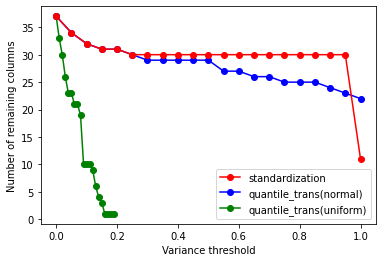

In [59]:
plt.plot(df_res_A['thresh']+0.0001, df_res_A['n_rem_cols'],
         '-or', label='standardization', zorder=10)
plt.plot(df_res_B['thresh']+0.0001, df_res_B['n_rem_cols'],
         '-ob', label='quantile_trans(normal)', zorder=5)
plt.plot(df_res_C['thresh']+0.0001, df_res_C['n_rem_cols'],
         '-og', label='quantile_trans(uniform)', zorder=1)

ax = plt.gca()
ax.set_xlabel('Variance threshold')
ax.set_ylabel('Number of remaining columns')
# ax.set_xscale('log')
ax.legend()
# ax.set_yscale('log')
plt.show()


Apart from 'mean_nb_items_per_ord' and 'single_purch, most of the low variance columns are, without surprise, dummy columns (region, payment type and category).
We will nevertheless keep the columns for the moment and try a feature selection.


#### PCA

In [67]:
# Data selection
sel_cols = [c for c in df_cust_vif.columns \
            if not (('cat_' in c)\
                    or ('paytype' in c)\
                    or ('reg' in c))]
print("Columns excluded :\n",
      [c for c in df_cust_vif if c not in sel_cols])

# Transformation and encoding
ct1 = CustTransformer(strat_low_card='ohe',
                      strat_quant='quant_norm')
ct2 = CustTransformer(strat_quant='stand')
df_sel_trans = ct2.fit_transform(ct1.fit_transform(df_cust_vif[sel_cols]))

Columns excluded :
 ['cust_region', 'paytype_not_defined_tot_nb', 'paytype_boleto_tot_nb', 'paytype_voucher_tot_nb', 'paytype_debit_card_tot_nb', 'cat_multimedia_tot_nb', 'cat_office_tot_nb', 'cat_leisure_tot_nb', 'cat_home_tot_nb', 'cat_food_tot_nb', 'cat_unknown_tot_nb', 'cat_diy_tot_nb', 'cat_electronics_tot_nb', 'cat_furniture_tot_nb', 'cat_hygiene_tot_nb', 'cat_fashion_tot_nb', 'cat_miscellaneous_tot_nb', 'cat_books_tot_nb']


In [62]:
from sklearn.decomposition import PCA

n_comp = len(df_sel_trans.columns)
pca = PCA(n_components=n_comp).fit(df_sel_trans)

# Performing pca
pca_comp = pd.DataFrame(pca.components_,
                      index=['PC'+str(i+1) for i in range(n_comp)],
                      columns=sel_cols).T

# Projection of the dataframe on all pca axes
df_proj_PCA = pd.DataFrame(pca.transform(df_sel_trans),
                           index=df_sel_trans.index,
                           columns=['PC'+str(i) for i in range(n_comp)])

Plotting heat map of the principal components

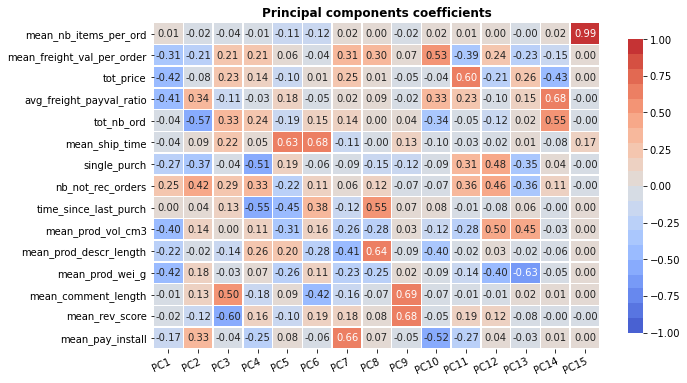

In [63]:
plot_heatmap(pca_comp,'Principal components coefficients',
             vmin=-1, vmax=1, center=0,
             palette=sns.color_palette("coolwarm", 20),
             figsize=(10,6),shape='rect')
plt.show()

Plotting explained variance ratio in scree plot

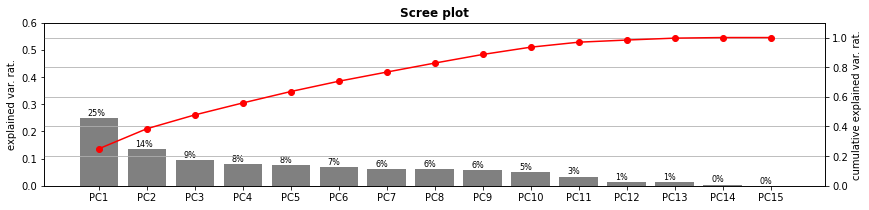

In [64]:
exp_var_rat = pca.explained_variance_ratio_
scree_plot(col_names= pca_comp.columns, exp_var_rat=exp_var_rat,
           ylim=(0,0.6), figsize=(14,3))
plt.grid()
plt.show()

Without the dummy columns, 80% of the variance of the 15 columns is in the 8 first principal components.
With a quantile transformation (normal) before the standardization, more variance can be obtained on the first axes.

#### UMAP

In [ ]:
# Data selection
sel_cols = [c for c in df_cust_vif.columns \
            if not (('cat_' in c)\
                    or ('paytype' in c)\
                    or ('reg' in c))]
print("Columns excluded :\n",
      [c for c in df_cust_vif if c not in sel_cols])

# Transformation and encoding
ct1 = CustTransformer(strat_low_card='ohe',
                      strat_quant='quant_norm')
ct2 = CustTransformer(strat_quant='stand')
df_sel_trans = ct2.fit_transform(ct1.fit_transform(df_cust_vif[sel_cols]))

Columns excluded :
 ['cust_region', 'paytype_not_defined_tot_nb', 'paytype_boleto_tot_nb', 'paytype_voucher_tot_nb', 'paytype_debit_card_tot_nb', 'cat_multimedia_tot_nb', 'cat_office_tot_nb', 'cat_leisure_tot_nb', 'cat_home_tot_nb', 'cat_food_tot_nb', 'cat_unknown_tot_nb', 'cat_diy_tot_nb', 'cat_electronics_tot_nb', 'cat_furniture_tot_nb', 'cat_hygiene_tot_nb', 'cat_fashion_tot_nb', 'cat_miscellaneous_tot_nb', 'cat_books_tot_nb']


In [66]:
from umap import UMAP

n_comp = len(df_sel_trans.columns)
# ind_samp = df_pca.sample(100).index

# UMAP instantiation
umap = UMAP(n_components=n_comp, random_state=14)
                    # n_neighbors=15, n_components=2,
                    # metric='euclidean', output_metric='euclidean',
                    # n_epochs=None, learning_rate=1.0,
                    # init='spectral', min_dist=0.1

# Fitting the model, projecting data on UMAP axes
df_proj_UMAP = pd.DataFrame(umap.fit_transform(df_cust_trans),
                           index=df_sel_trans.index,
                           columns=['UMAP'+str(i) for i in range(n_comp)])

### 1.2 KMeans clustering

In [83]:
from sklearn.cluster import KMeans

# km = KMeans(n_clusters=n, n_jobs=-1)
# km.fit(df)
# ser_clust = pd.Series(data=km.labels_,
#                       index=df.index)

# from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
# silh = silhouette_score(X=df,
#                         labels=ser_clust)
# dav_bould = davies_bouldin_score(X=df,
#                                  labels=ser_clust)
# cal_harab = calinski_harabasz_score(X=df,
#                                  labels=ser_clust)
# distor = km.inertia_
# silh, dav_bould, inertia

#### Preparing axes for visualisation

In [70]:
# PCA

from sklearn.decomposition import PCA

# Performing pca
pca = PCA(n_components=2).fit(df_cust_trans)

# Projection of the dataframe on the 2 first pca axes
df_proj_PCA_2D = pd.DataFrame(pca.transform(df_cust_trans),
                              index=df_cust_trans.index,
                              columns=['PC'+str(i) for i in range(2)])

In [78]:
# UMAP

from umap import UMAP

# Instantiation of UMAP
umap = UMAP(n_components=2, random_state=14)

# Projection of the dataframe on the 2 UMAP axes
df_proj_UMAP_2D = pd.DataFrame(umap.fit_transform(df_cust_trans),
                               index=df_cust_trans.index,
                               columns=['UMAP'+str(i) for i in range(2)])

In [ ]:
# t-SNE

from sklearn.manifold import TSNE

# Fitting the model
tsne = TSNE(n_components=2)
emb_tSNE = tsne.fit_transform(df_cust_trans, random_state=14)

# Projection of the dataframe on the 2 t-SNE axes
df_proj_tSNE_2D = pd.DataFrame(emb_tSNE,
                               index=df_cust_trans.index,
                               columns=['t-SNE'+str(i) for i in range(2)])

#### Choosing the best number of clusters

In [154]:
# Transformation and encoding
# Clustering with all the variables (colinear + low var + dummies)

ct = CustTransformer(strat_low_card='ohe',
                     strat_quant='stand')
df = ct.fit_transform(df_cust)

ind_samp = df.sample(1000).index
df = df.loc[ind_samp]

We'll try to find the best number of cluster against:
- distortion: the mean sum of squared distances to centers
- silhouette score: the mean ratio of intra-cluster and nearest-cluster distance
- calinski_harabasz score: the ratio of within to between cluster dispersion

In [164]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

silh_df, dav_bould_df, cal_harab_df, distor_df = \
    pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

# Looping on the number of clusters
for i, n in enumerate(range(2,8),1):
    silh, dav_bould, cal_harab, distor = [], [], [], []
    # Iterations of the same model (stability)
    for j in range(4): 
        km = KMeans(n_clusters=n, n_jobs=-1)
        km.fit(df)
        ser_clust = pd.Series(data=km.labels_, index=df.index)
        # Computing scores for iterations
        silh.append(silhouette_score(X=df,
                                     labels=ser_clust))
        dav_bould.append(davies_bouldin_score(X=df,
                                     labels=ser_clust))
        cal_harab.append(calinski_harabasz_score(X=df,
                                     labels=ser_clust))
        distor.append(km.inertia_)                        
    # Dataframe of the results on iterations
    df_res = pd.DataFrame({'Silhouette': silh,
                           'Davies_Bouldin': dav_bould,
                           'Calinsky_Harabasz': cal_harab,
                           'Distortion': inertia})
    df_res_agg = df_res.agg(['mean', 'median', 'std'])
    silh_df[n] = df_res_agg['Silhouette']
    dav_bould_df[n] = df_res_agg['Davies_Bouldin']
    cal_harab_df[n] = df_res_agg['Calinsky_Harabasz']
    distor_df[n] = df_res_agg['Distortion']

We'll plot the results:

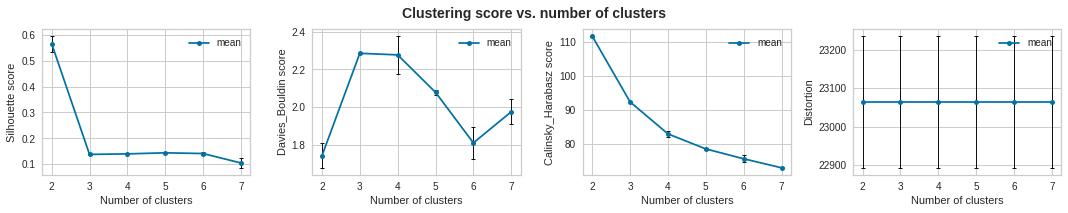

In [208]:
fig = plt.figure(figsize=(15,3))

def score_plot_vs_nb_clust(score_df, ax):
    score_df.T[['mean']].plot(yerr=score_df.loc['std'], elinewidth=1,
                              capsize=2, capthick=1, ecolor='k', fmt='-o',ms=5,
                              barsabove=False, uplims=False, ax=ax)

ax = fig.add_subplot(141)
score_plot_vs_nb_clust(silh_df, ax)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette score')

ax = fig.add_subplot(142)
score_plot_vs_nb_clust(dav_bould_df, ax)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Davies_Bouldin score')

ax = fig.add_subplot(143)
score_plot_vs_nb_clust(cal_harab_df, ax)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Calinsky_Harabasz score')

ax = fig.add_subplot(144)
score_plot_vs_nb_clust(distor_df, ax)

ax.set_xlabel('Number of clusters')
ax.set_ylabel('Distortion')

fig.suptitle('Clustering score vs. number of clusters',
             fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

#### Checking for the stability of the clustering

In [ ]:
# fig = plt.figure(figsize=(20,2))
 # # Plotting the nb of customers in each cluster
        # ax = fig.add_subplot(1,5,i)
        # val_c = ser_clust.value_counts()#.sort_index()
        # val_c.plot.bar()

#### Representation of customers of the clusters on the first axes of a PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Transformation and encoding
ct = CustTransformer(strat_low_card='ohe', # Ordinal encoding for 'region'
                     strat_quant='stand') # Standardization for quantitative data
df_cust_trans = ct.fit_transform(df_cust)
df_cust_trans.index = df_cust.index

# pca_cols = [c for c in df_cust.columns if not (('cat_' in c) or ('paytype' in c))]
pca_cols = df_cust_trans.columns
df_pca = df_cust_trans.loc[:, pca_cols]

n_comp = 20
pca = PCA(n_components=n_comp).fit(df_pca)

pca_df = pd.DataFrame(pca.components_,
                      index=['PC'+str(i+1) for i in range(n_comp)],
                      columns=pca_cols).T

df_pca_proj = pd.DataFrame(pca.transform(df_pca),
                           index=df_cust_trans.index,
                           columns=['PC'+str(i) for i in range(n_comp)])

Plotting principal components

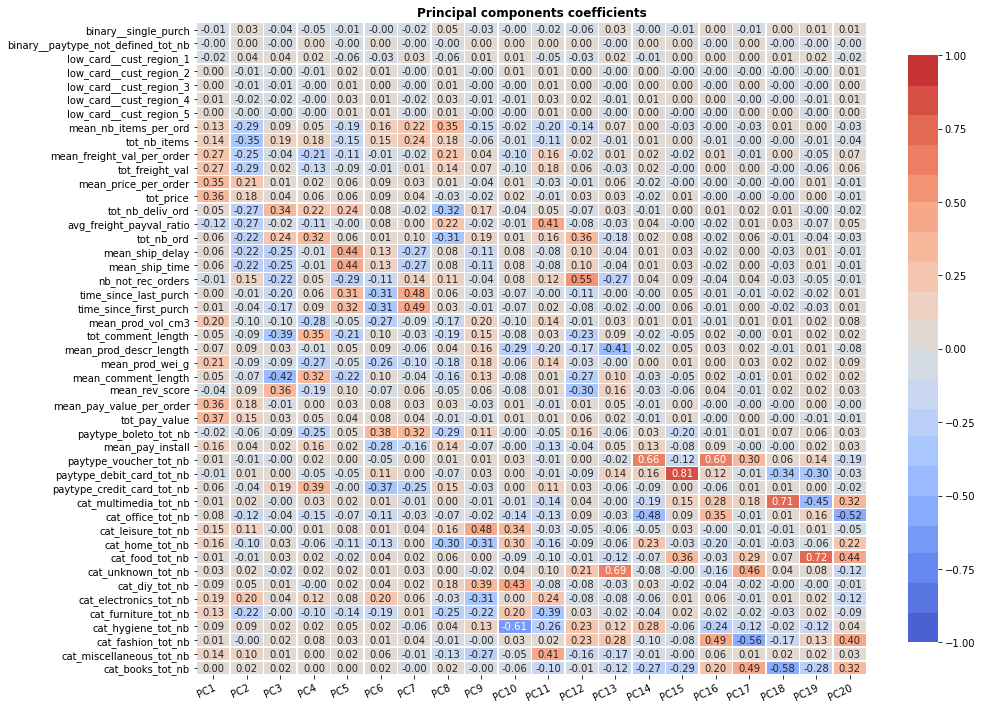

In [ ]:
plot_heatmap(pca_df,'Principal components coefficients',
             vmin=-1, vmax=1, center=0,
             palette=sns.color_palette("coolwarm", 20),
             figsize=(15,12),shape='rect')
plt.show()

Plotting explained variance ratio in scree plot

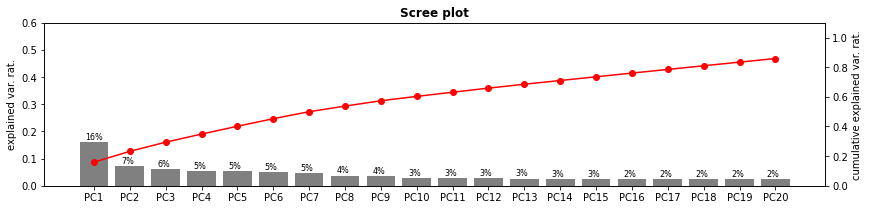

In [ ]:
exp_var_rat = pca.explained_variance_ratio_
scree_plot(col_names= pca_df.columns, exp_var_rat=exp_var_rat,
           ylim=(0,0.6), figsize=(14,3))
plt.show()

We plot the projection of the observations on the fist axes of the PCA, indicating in different colors the different clusters.

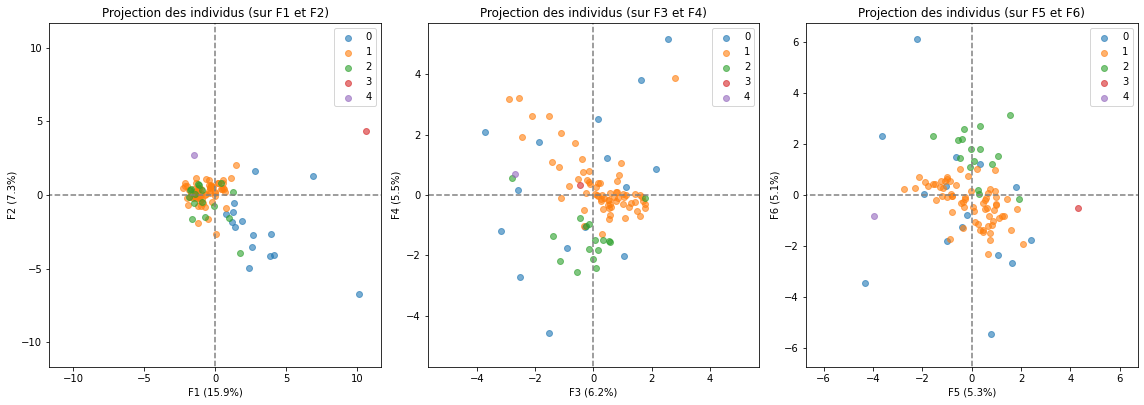

In [ ]:
## Essayer une normalisation des points avant affichage ?

sel_ind = clust.sample(100).index

display_factorial_planes(df_pca_proj.loc[sel_ind].values, n_comp=10, pca=pca,
                         axis_ranks=[(0,1),(2,3),(4,5)],
                         n_cols=3, labels=None,#df_pca_proj.loc[sel_ind].index,
                         illus_var=clust.loc[sel_ind],
                         lab_on=False, alpha=0.6)
plt.show()

NameError: ignored

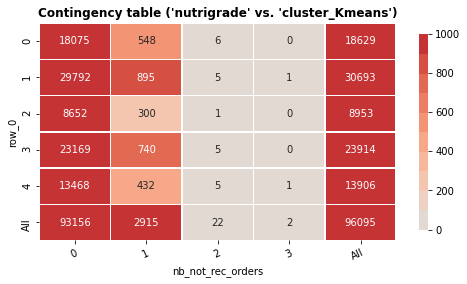

In [ ]:
## Creating table of contingency

data_crosstab = pd.crosstab(clust, 
                            df_cust['nb_not_rec_orders'],  
                               margins = True)

plot_heatmap(data_crosstab,"Contingency table ('nutrigrade' vs. 'cluster_Kmeans')",
             vmin=0, vmax=1000, palette=sns.color_palette("coolwarm", 20),
             figsize=(8,4), shape='rect', fmt='.0f')
if plot_enabled: plt.savefig(os.getcwd()+'/FIG/'+'A_4_2_nutrig_clusters.png', dpi=400);
plt.show()

In [ ]:
# Contingency table showing cluster vs. pnns1 categories

data_crosstab = pd.crosstab(df['pnns1'], 
                            df['cluster_Kmeans'],  
                               margins = True)
# display(data_crosstab

# Chi-Squared Test
from scipy.stats import chi2_contingency
stat, p, dof, expected = chi2_contingency(data_crosstab)
print('---'+"Chi-squared")
print('stat=%.3f, p=%.3f' % (stat, p))
print('Probably independent') if p > 0.05 else print('Probably dependent')

pca_df = pd.DataFrame(pca.components_,
                      index=['PC'+str(i+1) for i in range(n_comp)],
                      columns=pca_cols).T
plot_heatmap(data_crosstab,"Contingency table ('clusters' vs. 'pnns1')",
             vmin=0, vmax=1000,figsize=(10,4),shape='rect', fmt='.0f',
             palette=sns.color_palette("coolwarm", 20))
if plot_enabled: plt.savefig(os.getcwd()+'/FIG/'+'A_4_2_cont_tabl_clust_pnns1.png',
                             dpi=400);
plt.show()

In [ ]:
# Hierarchical Clustering

# Z = linkage(X_sc, 'ward')
# print(Z[0:15])
# plt.figure(figsize=(16,10))
# dendrogram(Z, labels = df.index, orientation = "right", count_sort='descending')
# plt.show()

# n_clust = 6
# clustH = fcluster(Z, n_clust, criterion='maxclust')
# df['cluster_HierClust'] = clustH
# clustH

### OPTIMISATION DES AXES UMAP

In [ ]:
for n in (15, 15):# 5, 10, 20, 50, 100, 200
    draw_umap(data=df_pca, n_neighbors=n, title='n_neighbors = {}'.format(n))

In [ ]:
for d in (0.0, 0.1, 0.25, 0.5, 0.8, 0.99):
    draw_umap(min_dist=d, title='min_dist = {}'.format(d))

In [50]:
def draw_umap(data, ser_clust, n_neighbors=15, min_dist=0.1, n_components=2,
              metric='euclidean', title='', figsize=(7,4), random_state=14):
    
    fit = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist,
                    n_components=n_components, metric=metric,
                    random_state= random_state)
    
    u = fit.fit_transform(data);
    fig = plt.figure(figsize=figsize)
    colors = c=[sns.color_palette()[x] for x in ser_clust.astype('int')]
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)),
                   c=colors)
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1],
                   c=colors)
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2],
                   c=colors, s=100)

    plt.title(title, fontsize=18)

# n_neighbors=15, n_components=2,
# metric='euclidean', metric_kwds=None, output_metric='euclidean', output_metric_kwds=None,
# n_epochs=None, learning_rate=1.0, init='spectral', min_dist=0.1,
# spread=1.0, low_memory=False,
# set_op_mix_ratio=1.0, local_connectivity=1.0, repulsion_strength=1.0,
# negative_sample_rate=5, transform_queue_size=4.0, a=None, b=None,
# random_state=None, angular_rp_forest=False, target_n_neighbors=-1,
# target_metric='categorical', target_metric_kwds=None, target_weight=0.5,
# transform_seed=42, force_approximation_algorithm=False, verbose=False,
# unique=False

# df_cust_trans # toutes les colonnes ohe + stand
# df_cust_vif # toutes les colonnes sauf corrélées
# df_enc_trans_A # df_cust_vif encodé ohe + stand
# df_sel_trans # sans les dummies - quant_norm + stand
# df_proj_PCA # meilleure projection PCA sans dummies et sans corrélées